In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

#check all the files in the input dataset
print(os.listdir("../input/"))

['FE_hourly.csv', 'NI_hourly.csv', 'DOM_hourly.csv', 'est_hourly.paruqet', 'PJMW_hourly.csv', 'COMED_hourly.csv', 'EKPC_hourly.csv', 'PJME_hourly.csv', 'DEOK_hourly.csv', 'DAYTON_hourly.csv', 'DUQ_hourly.csv', 'PJM_Load_hourly.csv', 'pjm_hourly_est.csv', 'AEP_hourly.csv']


Using TensorFlow backend.


In [2]:
#choosing DOM_hourly.csv data for analysis
fpath='../input/hourly-energy-consumption/DOM_hourly.csv'

df=pd.read_csv(fpath)
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [3]:
#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


- **Check if there are missing values in the data loaded**

In [4]:
#checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

Since there is no missing data in the data loaded we will not be dropping the missing value records or will not be imputing the data. We will proceed with the further data analysis.

- **Data visualization**

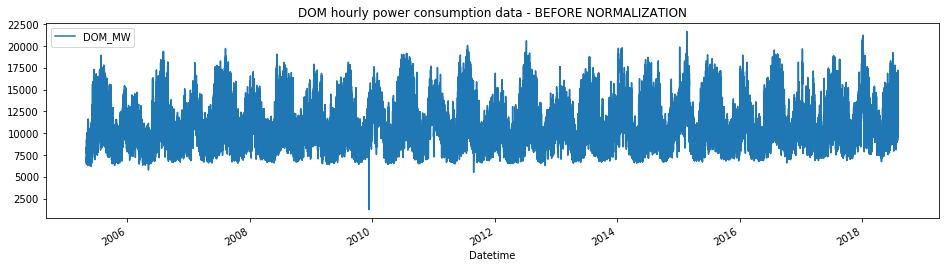

In [5]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

In [6]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

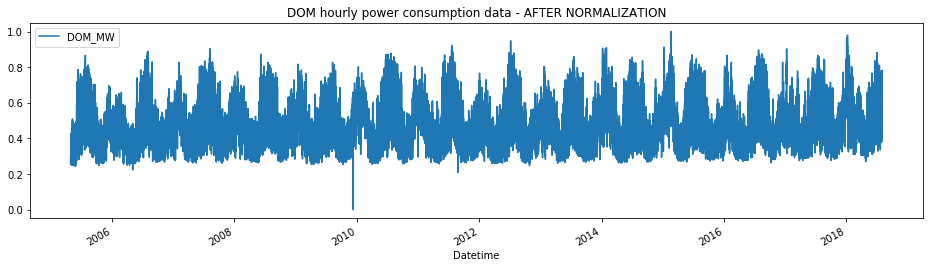

In [7]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [8]:
df_norm.shape

(116189, 1)

Prepare data for training the RNN models

In [9]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [10]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


Build a SIMPLE RNN model

In [11]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_3 (Dropout)  

In [12]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
110000/110000 [==============================] - 5s 46us/step - loss: 0.1207
Epoch 2/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0270
Epoch 3/10
110000/110000 [==============================] - 3s 32us/step - loss: 0.0144
Epoch 4/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0095
Epoch 5/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0072
Epoch 6/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0057
Epoch 7/10
110000/110000 [==============================] - 3s 30us/step - loss: 0.0048
Epoch 8/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0041
Epoch 9/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0036
Epoch 10/10
110000/110000 [==============================] - 4s 33us/step - loss: 0.0031


Lets check the accuracy of the model by comparing it to the y_test data

In [13]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9451304414415442


Let's compare the actual values vs predicted values by plotting a graph

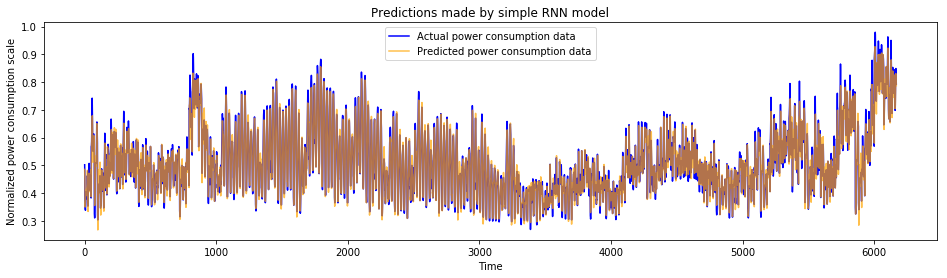

In [14]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")